**Module: Computer Vision Project 2**

**Name: Priyanka Balakrishna Hejmadi**


## Part A

1. Import and Understand the data [7 Marks]

In [1]:
%tensorflow_version 2.x
!pip install tensorflow==2.7.0
import tensorflow
tensorflow.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'2.7.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# A. Import and read ‘images.npy’. [1 Marks]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input

df = np.load('/content/drive/MyDrive/CV_project2_files/images.npy', allow_pickle=True)
df.shape


(409, 2)

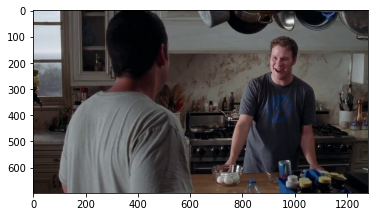

In [4]:
plt.imshow(df[1][0])

In [5]:
df[1][0].shape

(697, 1280, 4)

In [6]:
type(df)

numpy.ndarray

In [7]:
# B. Split the data into Features(X) & labels(Y). Unify shape of all the images. [3 Marks]


In [10]:
count = 1


import time
import cv2
start = time.time()
X = []
Y = []
for image in df:
    i=0
    img = image[0]
    metadata = image[1]
    mask = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)
    for data in metadata:
        height = data['imageHeight']
        width = data['imageWidth']
        points = data['points']
        if 'Face' in data['label']:
            x1 = round(width*points[0]['x'])
            y1 = round(height*points[0]['y'])
            x2 = round(width*points[1]['x'])
            y2 = round(height*points[1]['y'])
      
            mask[y1:y2,x1:x2] = 1 
            
    cv2.imwrite('/content/drive/MyDrive/CV_project2_files/face_image_{}.jpg'.format(count),img)  
    cv2.imwrite('/content/drive/MyDrive/CV_project2_files/image_mask_{}.jpg'.format(count),mask) # save mask

    Y.append(cv2.resize(mask, (28,28), interpolation = cv2.INTER_NEAREST))
    #Pre-processing image for input into MobileNet
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    img = preprocess_input(np.array(img, dtype=np.float32))
    X.append(img)
    count += 1
   



In [11]:
# Convert to numpy array
X1 = np.array(X)
Y1 = np.array(Y, dtype=np.float32)

In [12]:
#C. Split the data into train and test[400:9]. [1 Marks]
X_train = X1[:400]
X_test = X1[400:]
Y_train = Y1[:400]
Y_test = Y1[400:]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(400, 224, 224, 3)
(400, 28, 28)
(9, 224, 224, 3)
(9, 28, 28)


In [13]:
# D. Select random image from the train data and display original image and masked image. [2 Marks]
mask1 = cv2.imread("/content/drive/MyDrive/CV_project2_files/image_mask_11.jpg")
face1 = cv2.imread("/content/drive/MyDrive/CV_project2_files/face_image_11.jpg")

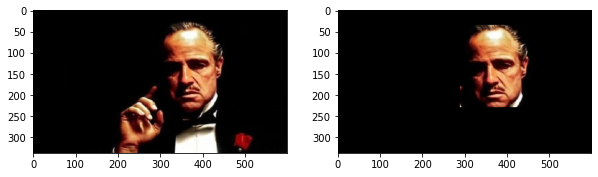

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(np.squeeze(face1), cmap='gray')
ax2.imshow(np.squeeze(face1*mask1), cmap='gray')
plt.show()

#### 2. Model building [11 Marks]

In [15]:
# A. Design a face mask detection model. [4 Marks]

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(224, 224, 3), include_top=False, alpha=1, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((28, 28))(x)

    return Model(inputs=model.input, outputs=x)

In [16]:
# B. Design your own Dice Coefficient and Loss function. [2 Marks]
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [17]:
# C. Train and tune the model as required. [3 Marks]

model = create_model(False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [19]:
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=50, batch_size=54, verbose=1)

Epoch 1/50
8/8 [==============================] - 8s 241ms/step - loss: 2.3227 - dice_coefficient: 0.2169 - val_loss: 2.2310 - val_dice_coefficient: 0.1911
Epoch 2/50
8/8 [==============================] - 1s 79ms/step - loss: 2.1845 - dice_coefficient: 0.2159 - val_loss: 2.1170 - val_dice_coefficient: 0.1975
Epoch 3/50
8/8 [==============================] - 1s 83ms/step - loss: 2.0770 - dice_coefficient: 0.2255 - val_loss: 2.0011 - val_dice_coefficient: 0.2123
Epoch 4/50
8/8 [==============================] - 1s 80ms/step - loss: 1.9884 - dice_coefficient: 0.2396 - val_loss: 1.8868 - val_dice_coefficient: 0.2311
Epoch 5/50
8/8 [==============================] - 1s 80ms/step - loss: 1.8772 - dice_coefficient: 0.2553 - val_loss: 1.7826 - val_dice_coefficient: 0.2504
Epoch 6/50
8/8 [==============================] - 1s 79ms/step - loss: 1.7952 - dice_coefficient: 0.2716 - val_loss: 1.6918 - val_dice_coefficient: 0.2666
Epoch 7/50
8/8 [==============================] - 1s 80ms/step - loss

###### D. Evaluate and share insights on performance of the model. [2 Marks]
The model gives a dice coefficient of 0.5686 and a validation loss of 0.7646

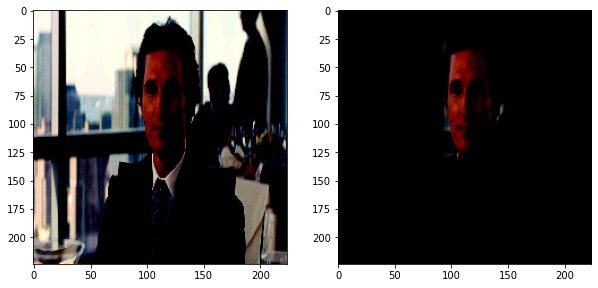

In [20]:
#3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image. [2 Marks]
import matplotlib.pyplot as plt


unscaled = X_test[3]
image = cv2.resize(unscaled, (224, 224))
image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)


pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]), batch_size=1)[0] > 0.5), (224,224))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(unscaled, cmap='gray')
ax2.imshow(out_image, cmap='gray')
plt.show()


# Part B

PROJECT OBJECTIVE To create an image dataset to be used by AI team build an image classifier data. Profile images of people are given.

In [21]:
import pandas as pd
import numpy as np

In [22]:
# 1. Read/import images from folder ‘training_images’. [2 Marks]

project_path = '/content/drive/MyDrive/CV_project2_files/'

images_zip_path = project_path + 'training_images-20211126T092819Z-001.zip'

from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()


In [23]:
# 2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images. [3 Marks]
# 3. From the same loop above, extract metadata of the faces and write into a DataFrame. [3 Marks]



In [24]:
import os
faces_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])

face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/CV_project2_files/haarcascade_frontalface_default.xml')
folder_dir = '/content/training_images/'

for images in os.listdir(folder_dir):
  img = cv2.imread(folder_dir + images)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in faces:
    dict = {'x': x ,'y': y, 'w': w, 'h': h,'Total_Faces': len(faces), 'Image_Name': images}
    faces_df = faces_df.append(dict, ignore_index = True)


In [25]:
faces_df.head()

,x,y,w,h,Total_Faces,Image_Name
0,67,114,403,403,1,real_00907.jpg
1,269,260,76,76,1,real_00684.jpg
2,49,49,507,507,1,real_00237.jpg
3,100,199,348,348,1,real_00301.jpg
4,102,110,438,438,1,real_00669.jpg


In [26]:
faces_df.shape

(694, 6)

In [27]:
# 4. Save the output Dataframe in .csv format. [2 Marks]
faces_df.to_csv('faces_metadata.csv')

# Part C

PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

In [28]:
# 1. Unzip, read and Load data(‘PINS.zip’) into session. [2 Marks]
project_path = '/content/drive/MyDrive/CV_project2_files/'

images_zip_path = project_path + 'PINS.zip'

from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()


In [29]:
folder_path ='/content/PINS'
# 2. Write function to create metadata of the image. [4 Marks]

import numpy as np
import pandas as pd
import os
from PIL import Image
def create_metadata(path, base, file):
  image = Image.open(path +'/'+ base +'/'+ file)
  info_dict = {
  'Filename': image.filename,
  'Name': base,
  "Image Size": image.size,
  "Image Height": image.height,
  "Image Width": image.width,
  "Image Format": image.format,
  "Image Mode": image.mode,
  "Image is Animated": getattr(image, "is_animated", False),
  "Frames in Image": getattr(image, "n_frames", 1)
              }
  return info_dict

In [30]:
# 3. Write a loop to iterate through each and every image and create metadata for all the images. [4 Marks]
def load_metadata(path):
    metadata=[]
    #metadata = pd.DataFrame(columns=['Filename','Image Size','Image Height','Image Width','Image Format','Image Mode','Image is Animated','Frames in Image'])
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
          info_dict = create_metadata(path,i,f)
          ext = os.path.splitext(f)[1]
          if ext == '.jpg' or ext == '.jpeg':
            metadata.append(info_dict) #, ignore_index=True)
    return pd.DataFrame(metadata)

In [31]:
meta_df = load_metadata(folder_path)

In [32]:
meta_df.head()

,Filename,Name,Image Size,Image Height,Image Width,Image Format,Image Mode,Image is Animated,Frames in Image
0,/content/PINS/pins_brie larson/brie larson114.jpg,pins_brie larson,"(299, 299)",299,299,JPEG,RGB,False,1
1,/content/PINS/pins_brie larson/brie larson40.jpg,pins_brie larson,"(299, 299)",299,299,JPEG,RGB,False,1
2,/content/PINS/pins_brie larson/brie larson124.jpg,pins_brie larson,"(299, 299)",299,299,JPEG,RGB,False,1
3,/content/PINS/pins_brie larson/brie larson5.jpg,pins_brie larson,"(299, 299)",299,299,JPEG,RGB,False,1
4,/content/PINS/pins_brie larson/brie larson43.jpg,pins_brie larson,"(299, 299)",299,299,JPEG,RGB,False,1


In [33]:
import cv2
def load_image(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

In [34]:
load_image(meta_df['Filename'][0])

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 1, 2],
        [0, 0, 1],
        [0, 0, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 2]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [35]:
# 4. Generate Embeddings vectors on the each face in the dataset. [4 Marks]
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [36]:
model = vgg_face()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

In [37]:
WEIGHTS_FILE = project_path + "vgg_face_weights.h5"
model.load_weights(WEIGHTS_FILE)

In [38]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [39]:
img_path = meta_df['Filename'][0]
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [40]:
embeddings = np.zeros((meta_df.shape[0], 2622))

for i in range(0, len(meta_df)):
  img_path = meta_df['Filename'][i]
  img = load_image(img_path)

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)

  img = cv2.resize(img, dsize = (224,224))
  #print(img.shape)

  # Obtain embedding vector for an image
  # Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

  embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
  



In [41]:
# 5. Build distance metrics for identifying the distance between two similar and dissimilar images. [4 Marks]
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

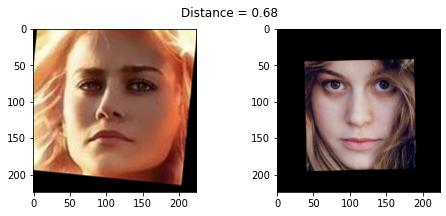

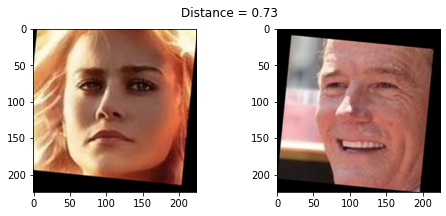

In [42]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(meta_df['Filename'][idx1]))
    plt.subplot(122)
    plt.imshow(load_image(meta_df['Filename'][idx2]));    

show_pair(2, 5)
show_pair(2, 184)

In [43]:
# 6. Use PCA for dimensionality reduction. [2 Marks]


from sklearn.decomposition import PCA
pca = PCA(n_components=128)
principalComponents = pca.fit_transform(embeddings)



In [44]:
principalComponents[:10]

array([[ 0.17196448, -0.09320312,  0.16204223, ..., -0.01074814,
        -0.01471112,  0.01675251],
       [ 0.07697679, -0.01047374,  0.26093188, ...,  0.01432799,
         0.00121267, -0.00195553],
       [ 0.17570633,  0.05983892,  0.11371336, ...,  0.00729002,
         0.05065924,  0.03067675],
       ...,
       [ 0.16106204, -0.03624073,  0.19214603, ..., -0.02776844,
        -0.01335804, -0.00696364],
       [ 0.11215882, -0.10944181,  0.1019099 , ..., -0.01275558,
         0.00112917,  0.00172544],
       [ 0.21069995, -0.04973018,  0.11680743, ...,  0.00371153,
        -0.00978291,  0.00382252]])

In [45]:
# 7. Build an SVM classifier in order to map each image to its right person. [4 Marks]

train_idx = np.arange(meta_df.shape[0]) % 9 != 0
test_idx = np.arange(meta_df.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = principalComponents[train_idx]
# another half as test examples of 10 identities
X_test = principalComponents[test_idx]

targets = np.array(meta_df['Name'])
y_train = targets[train_idx]
y_test = targets[test_idx]



In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


In [47]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf' , class_weight='balanced' , C=1000 , gamma=0.0082)
svm.fit(X_train , y_train)
print(svm.score(X_test , y_test))


0.9624060150375939


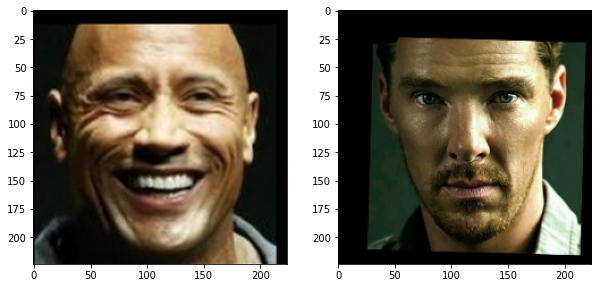

In [48]:
#8. Import and display the the test images. [2 Marks]
img1 = load_image('/content/drive/MyDrive/CV_project2_files/Dwayne+Johnson4.jpg')
img2 = load_image('/content/drive/MyDrive/CV_project2_files/Benedict+Cumberbatch9.jpg')
img1 = (img1 / 255.).astype(np.float32)
img1 = cv2.resize(img1, dsize = (224,224))
img2 = (img2 / 255.).astype(np.float32)
img2 = cv2.resize(img2, dsize = (224,224))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')
plt.show()

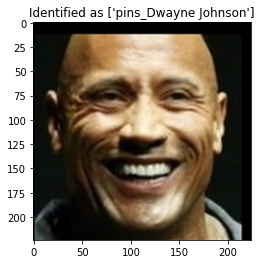

In [49]:
#9. Use the trained SVM model to predict the face on both test images. [4 Marks]
emb_img1 = vgg_face_descriptor.predict(np.expand_dims(img1, axis=0))[0]
img1_pca = pca.transform([emb_img1])
y_pred = svm.predict(img1_pca)
y_predict_encoded = le.inverse_transform(y_pred)

plt.imshow(img1)
plt.title(f'Identified as {y_predict_encoded}');


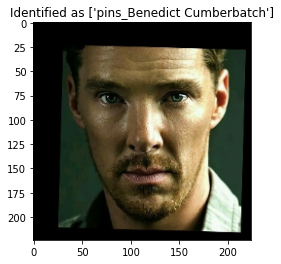

In [50]:
emb_img2 = vgg_face_descriptor.predict(np.expand_dims(img2, axis=0))[0]
img2_pca = pca.transform([emb_img2])
y_pred2 = svm.predict(img2_pca)
y_predict_encoded2 = le.inverse_transform(y_pred2)

plt.imshow(img2)
plt.title(f'Identified as {y_predict_encoded2}');